In [1]:
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
#matplotlib.rc('font', **font)
cstring = 'rgbcmyk'
import matplotlib as ml
%matplotlib inline
ml.rcParams['figure.figsize'] = (8.0, 5.0)
ml.rcParams['text.usetex'] =True
ml.rc('font', family='serif',size=20)

In [2]:
g0 = 3100
g1 = 380
g3 = 290
g4 = 141
g2 = -15

In [3]:
def getBMatrix(kx, ky, kz):
    kx, ky = np.asarray(kx), np.asarray(ky)
    tk = np.exp(ky*1j/np.sqrt(3))+2*np.exp(-ky*1j/(2*np.sqrt(3)))*np.cos(kx/2)
    tkc = np.conj(tk)
    tz = np.exp(kz*1j)
    tzc = np.conj(tz)
    idt = np.ones(kx.shape, dtype=float)
    Hl = np.array([[-g4*(tk*tz+tkc*tzc), g0*tkc-g3*tkc*tzc+g1*tz+0.5*g2*tzc**2],
                   [g0*tk-g3*tk*tz+g1*tzc+0.5*g2*tz**2, -g4*(tk*tz+tkc*tzc)]])
    return np.moveaxis(Hl, [0,1], [-2,-1])

def getBMatrixVal(kx, ky, kz, xi):
    v0 = 0.5 * np.sqrt(3) * g0
    v3 = -0.5 * np.sqrt(3) * g3
    v4 = -0.5 * np.sqrt(3) * g4
    kx, ky = np.asarray(kx), np.asarray(ky)
    tk = xi * kx + ky * 1j
    tkc = xi * kx - ky * 1j
    tz = np.exp(kz*1j)
    tzc = np.conj(tz)
    idt = np.ones(kx.shape, dtype=float)
    Hl = np.array([[v4*(tk*tz+tkc*tzc), v0*tkc+v3*tkc*tzc+g1*tz+0.5*g2*tzc**2],
                   [v0*tk+v3*tk*tz+g1*tzc+0.5*g2*tz**2, v4*(tk*tz+tkc*tzc)]])
    return np.moveaxis(Hl, [0,1], [-2,-1])

def getBMatrixABCAB(kx, ky, Dt, mu, xi):
    v0 = 0.5 * np.sqrt(3) * g0
    v3 = 0.5 * np.sqrt(3) * g3
    v4 = 0.5 * np.sqrt(3) * g4
    kx, ky = np.asarray(kx), np.asarray(ky)
    p =  xi * kx + ky * 1j
    pc = xi * kx - ky * 1j
    Dt2=0
    Dt3=0
    Dt4=0
    Dtp=-10.5
    idt = np.ones(kx.shape, dtype=float)
    Hl = np.array([[(Dt + 2*Dt2 - Dt4 + Dtp - mu)*idt, v0*pc, -v4*pc, -v3*p, 0*idt, 0.5*g2*idt, 0*idt, 0*idt, 0*idt, 0*idt],
                   [v0*p, (Dt + 2*Dt2 - Dt4 - mu)*idt, g1*idt, -v4*pc, 0*idt, 0*idt, 0*idt, 0*idt, 0*idt, 0*idt],
                   [-v4*p, g1*idt, (Dt/2 - Dt2 - Dt3 - Dt4 - mu)*idt, v0*pc, -v4*pc, -v3*p, 0*idt, 0.5*g2*idt, 0*idt, 0*idt],
                   [-v3*pc, -v4*p, v0*p, (Dt/2 - Dt2 - Dt3 - Dt4 - mu)*idt, g1*idt, -v4*pc, 0*idt, 0*idt, 0*idt, 0*idt],
                   [0*idt, 0*idt, -v4*p, g1*idt,(-2*Dt2 + 4*Dt4 - mu)*idt, v0*pc, -v4*pc, -v3*p, 0*idt, 0.5*g2*idt],
                   [0.5*g2*idt, 0*idt, -v3*pc, -v4*p, v0*p, (-2*Dt2 + 4*Dt4 - mu)*idt, g1*idt, -v4*pc, 0*idt, 0*idt],
                   [0*idt, 0*idt, 0*idt, 0*idt, -v4*p, g1*idt, (-Dt/2 - Dt2 + Dt3 - Dt4 - mu)*idt, v0*pc, -v4*pc, -v3*p],
                   [0*idt, 0*idt, 0.5*g2*idt, 0*idt, -v3*pc, -v4*p, v0*p, (-Dt/2 - Dt2 + Dt3 - Dt4 - mu)*idt, g1*idt, -v4*pc],
                   [0*idt, 0*idt, 0*idt, 0*idt, 0*idt, 0*idt, -v4*p, g1*idt, (-Dt + 2*Dt2 - Dt4 - mu)*idt, v0*pc],
                   [0*idt, 0*idt, 0*idt, 0*idt, 0.5*g2*idt, 0*idt, -v3*pc, -v4*p, v0*p, (-Dt + 2*Dt2 - Dt4 + Dtp - mu)*idt]])
    return np.moveaxis(Hl, [0,1], [-2,-1])

In [4]:
GS = np.array([0,0,0])
KS = np.array([4*np.pi/3,0,0])
MS = np.array([np.pi, np.pi/np.sqrt(3),0])
AS = np.array([0,0,np.pi])
LS = np.array([np.pi, np.pi/np.sqrt(3),np.pi])
HS = np.array([4*np.pi/3,0,np.pi])

Nd = 300
ir = np.arange(Nd)[:,np.newaxis]
irh = np.arange(Nd/2)[:,np.newaxis]
grid =np.concatenate((KS+(ir/Nd)*(GS-KS),GS+(ir/Nd)*(MS-GS),MS+(2*irh/Nd)*(KS-MS),
                     KS+(2*irh/Nd)*(HS-KS), HS+(ir/Nd)*(AS-HS), AS+(ir/Nd)*(LS-AS),
                      LS+(2*irh/Nd)*(HS-LS), HS+(2*irh/Nd)*(KS-HS)))
w,_=np.linalg.eigh(getBMatrix(grid[:,0], grid[:,1], grid[:,2]))

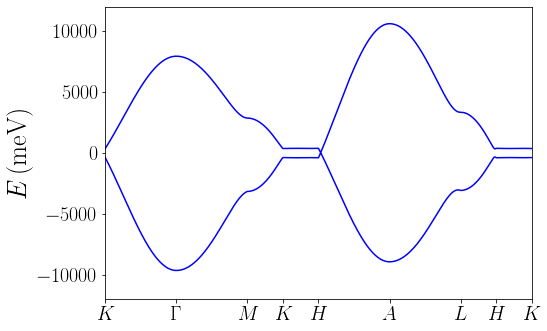

In [5]:
ml.rcParams['figure.figsize'] = (8.0, 5.0)
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(grid.shape[0]),w,'b')
ax.set_ylim([-12000,12000])
ax.set_ylabel(r'$E\,(\mathrm{meV})$',fontsize=26)
ax.set_xticks([0,Nd,2*Nd,2*Nd+Nd//2,3*Nd, 4*Nd,5*Nd,5*Nd+Nd//2, 6*Nd])
ax.set_xlim([0,6*Nd])
ax.set_xticklabels([r'$K$', r'$\Gamma$', r'$M$', r'$K$', r'$H$', r'$A$', r'$L$', r'$H$', r'$K$'])
plt.tight_layout()
plt.show()

In [6]:
np.linalg.eigh(getBMatrix(-0.1, -0.2, -0.3))[0]

array([-9603.19284808,  7993.48360719])

In [7]:
kx=np.linspace(-4*np.pi/3-0.4,4*np.pi/3+0.4,4000)
ky=-0.0*np.ones(kx.shape)
kz = -0.0*np.pi*np.ones(kx.shape)
#kz1 = np.pi*np.ones(kx.shape)
w1,_=np.linalg.eigh(getBMatrix(kx, ky, kz))
#w2,_=np.linalg.eigh(getBMatrixVal(kx, ky, kz,-1))

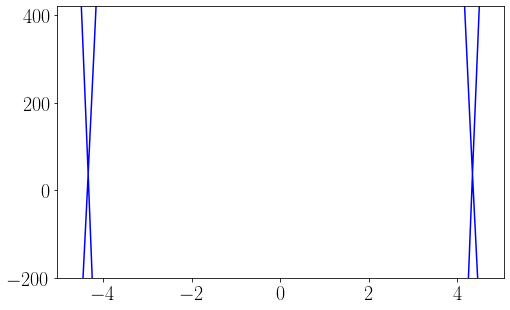

In [8]:
ml.rcParams['figure.figsize'] = (8.0, 5.0)
plt.plot(kx,w1[:],'b')
#plt.plot(kx,w2,'r')
plt.ylim([-200,420])
#plt.xlim([-0.4,+0.4])
plt.show()

In [52]:
4*np.pi/3-0.3

3.8887902047863907

In [70]:
kx=np.linspace(-4*np.pi/3-0.3,4*np.pi/3+0.3,3000)
#ky=np.linspace(-0.3,0.3,3000)
KX,KY=np.meshgrid(kx,kx)
KX = np.ravel(KX)
KY = np.ravel(KY)
kz = 0.2*np.pi*np.ones(KX.shape)
w1,_=np.linalg.eigh(getBMatrix(KX, KY, kz))

In [231]:
kzl = np.linspace(0,np.pi,100,endpoint=True)
kxl = []
kyl = []
KX,KY=np.meshgrid(kx,kx)
KX = np.ravel(KX)
KY = np.ravel(KY)
for ikz, kz in enumerate(kzl):
    w,_ = np.linalg.eigh(getBMatrix(KX, KY, kz*np.ones(KX.shape)))
    ind1 = np.argsort(w[:,1]-w[:,0])
    kxl.append(KX[ind1][:6])
    kyl.append(KY[ind1][:6])

In [71]:
ind1=np.argsort(w1[:,1]-w1[:,0])

In [72]:
w1[ind1][:6][:,1]-w1[ind1][:6][:,0]

array([1.11614649, 1.11614649, 6.43865547, 6.43865547, 6.68104046,
       6.68104046])

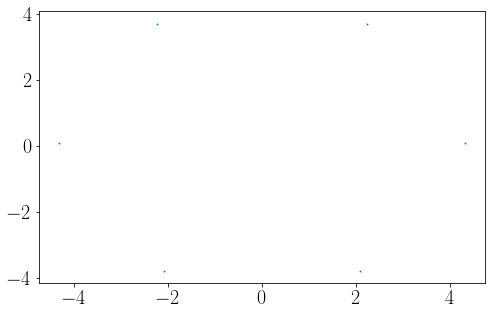

In [78]:
plt.scatter(KX[ind1][:6],KY[ind1][:6],s=0.8)

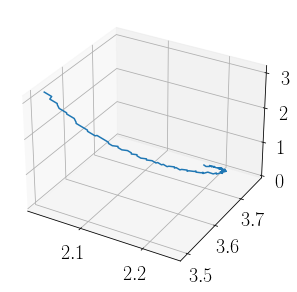

In [298]:
from mpl_toolkits.mplot3d import Axes3D
ml.rcParams['figure.figsize'] = (8.0, 5.0)
fig = plt.figure()
ax = fig.gca(projection='3d')
kx0 = []
ky0 = []
kz0 = []
for ik in range(len(kxl)):
    ind = np.where((kxl[ik]>1.5)&(kxl[ik]<3.5)&(kyl[ik]>0))[0]
    if len(ind)>0:
        kx0.append(kxl[ik][ind][0])
        ky0.append(kyl[ik][ind][0])
        kz0.append(kzl[ik])
kx0,ky0,kz0 = np.array(kx0),np.array(ky0),np.array(kz0)
ax.plot(kx0,ky0,kz0)
#ax.contour(KX,KY,w1[:,:,1]-w1[:,:,0],[20])
plt.show()

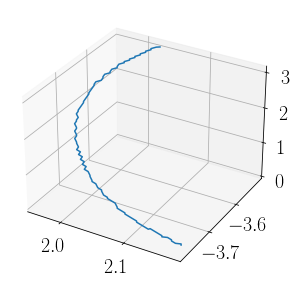

In [299]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
kx1 = []
ky1 = []
kz1 = []
for ik in range(len(kxl)):
    ind = np.where((kxl[ik]>1.5)&(kxl[ik]<3.5)&(kyl[ik]<0))[0]
    if len(ind)>0:
        kx1.append(kxl[ik][ind][0])
        ky1.append(kyl[ik][ind][0])
        kz1.append(kzl[ik])
kx1,ky1,kz1 = np.array(kx1),np.array(ky1),np.array(kz1)
ax.plot(kx1,ky1,kz1)
#ax.contour(KX,KY,w1[:,:,1]-w1[:,:,0],[20])

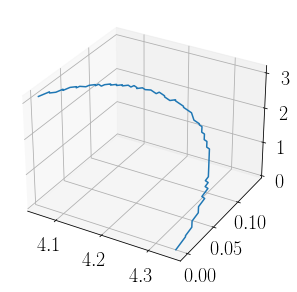

In [300]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
kx2 = []
ky2 = []
kz2 = []
for ik in range(len(kxl)):
    ind = np.where(kxl[ik]>3.5)[0]
    if len(ind)>0:
        kx2.append(kxl[ik][ind][0])
        ky2.append(kyl[ik][ind][0])
        kz2.append(kzl[ik])
kx2,ky2,kz2 = np.array(kx2),np.array(ky2),np.array(kz2)
ax.plot(kx2,ky2,kz2)
#ax.contour(KX,KY,w1[:,:,1]-w1[:,:,0],[20])

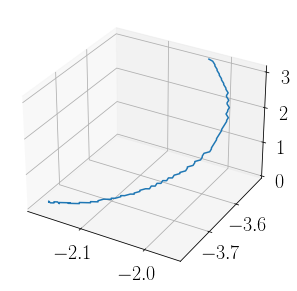

In [301]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
kx3 = []
ky3 = []
kz3 = []
for ik in range(len(kxl)):
    ind = np.where((kxl[ik]<-1.5)&(kxl[ik]>-3.5)&(kyl[ik]<0))[0]
    if len(ind)>0:
        kx3.append(kxl[ik][ind][0])
        ky3.append(kyl[ik][ind][0])
        kz3.append(kzl[ik])
kx3,ky3,kz3 = np.array(kx3),np.array(ky3),np.array(kz3)
ax.plot(kx3,ky3,kz3)
#ax.contour(KX,KY,w1[:,:,1]-w1[:,:,0],[20])

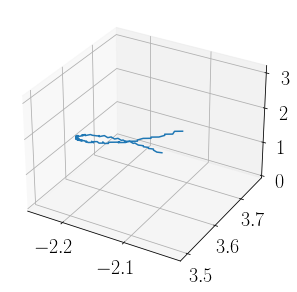

In [302]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
kx4 = []
ky4 = []
kz4 = []
for ik in range(len(kxl)):
    ind = np.where((kxl[ik]<-1.5)&(kxl[ik]>-3.5)&(kyl[ik]>0))[0]
    if len(ind)>0:
        kx4.append(kxl[ik][ind][0])
        ky4.append(kyl[ik][ind][0])
        kz4.append(kzl[ik])
kx4,ky4,kz4 = np.array(kx4),np.array(ky4),np.array(kz4)
ax.plot(kx4,ky4,kz4)
#ax.contour(KX,KY,w1[:,:,1]-w1[:,:,0],[20])

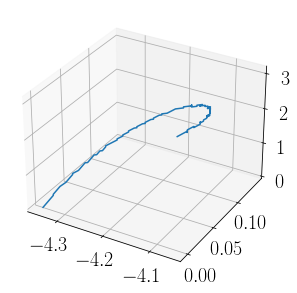

In [303]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
kx5 = []
ky5 = []
kz5 = []
for ik in range(len(kxl)):
    ind = np.where(kxl[ik]<-3.5)[0]
    if len(ind)>0:
        kx5.append(kxl[ik][ind][0])
        ky5.append(kyl[ik][ind][0])
        kz5.append(kzl[ik])
kx5,ky5,kz5 = np.array(kx5),np.array(ky5),np.array(kz5)
ax.plot(kx5,ky5,kz5)
#ax.contour(KX,KY,w1[:,:,1]-w1[:,:,0],[20])

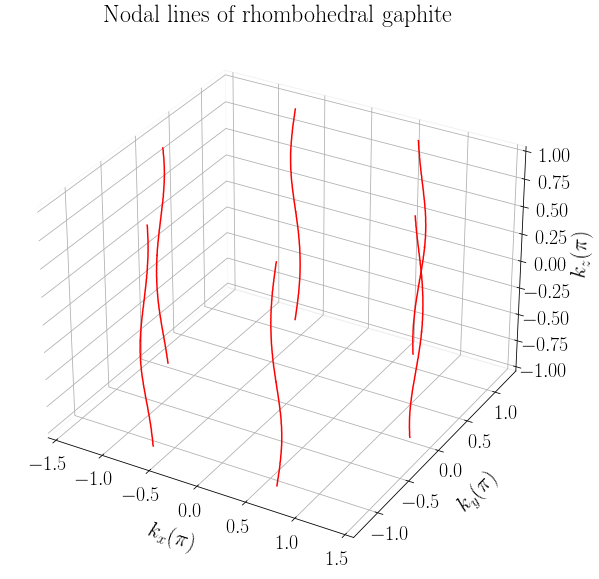

In [371]:
ml.rcParams['figure.figsize'] = (10.0, 10.0)
ml.rcParams['axes.labelpad'] = 16
ml.rcParams['axes.titlepad'] = 4
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(kx0/np.pi,ky0/np.pi,kz0/np.pi,'r')
ax.plot(-kx0/np.pi,-ky0/np.pi,-kz0/np.pi,'r')
#ax.plot(np.cos(2*np.pi/3)*np.array(kx2)+np.sin(2*np.pi/3)*np.array(ky2),-np.sin(2*np.pi/3)*np.array(kx2)+np.cos(2*np.pi/3)*np.array(ky2),kz2)
ax.plot(kx1/np.pi,ky1/np.pi,kz1/np.pi,'r')
ax.plot(-kx1/np.pi,-ky1/np.pi,-kz1/np.pi,'r')
ax.plot(kx2/np.pi,ky2/np.pi,kz2/np.pi,'r')
ax.plot(-kx2/np.pi,-ky2/np.pi,-kz2/np.pi,'r')
ax.plot(kx3/np.pi,ky3/np.pi,kz3/np.pi,'r')
ax.plot(-kx3/np.pi,-ky3/np.pi,-kz3/np.pi,'r')
ax.plot(kx4/np.pi,ky4/np.pi,kz4/np.pi,'r')
ax.plot(-kx4/np.pi,-ky4/np.pi,-kz4/np.pi,'r')
ax.plot(kx5/np.pi,ky5/np.pi,kz5/np.pi,'r')
ax.plot(-kx5/np.pi,-ky5/np.pi,-kz5/np.pi,'r')
ax.set_xlabel(r'$k_x (\pi)$',fontsize=22)
ax.set_ylabel(r'$k_y (\pi)$',fontsize=22)
ax.set_zlabel(r'$k_z (\pi)$',fontsize=22)
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.tick_params(axis='z', which='major', pad=10)
#ax.dist = 9
ax.set_title("Nodal lines of rhombohedral gaphite")
plt.savefig('Graphite.pdf')

In [53]:
kx=np.linspace(-0.2,0.2,1000)
ky=np.zeros(kx.shape)
kz = 0.0*np.ones(kx.shape)
kz1 = 0.95*np.pi*np.ones(kx.shape)
w1,_=np.linalg.eigh(getBMatrixVal(kx, ky, kz, -1))
w2,_=np.linalg.eigh(getBMatrixVal(kx, ky, kz1, -1))
w3,_=np.linalg.eigh(getBMatrixABCAB(kx, ky, 0.0, 0.0, -1))

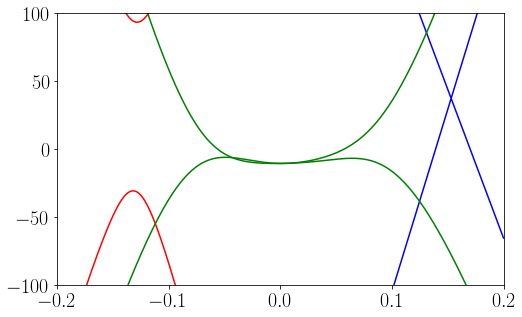

In [54]:
ml.rcParams['figure.figsize'] = (8.0, 5.0)
plt.plot(kx,w1,'b')
plt.plot(kx,w2,'r')
plt.plot(kx,w3,'g')
plt.ylim([-100,100])
plt.xlim([-0.2,0.2])
plt.show()

In [56]:
3*334/4

250.5